In [ ]:
# default_exp overlap.comp_uncomp

In [ ]:
#export
import numpy as np
from fisherman.utils import sym_from_triu, is_exact_simulation

from qiskit import QuantumCircuit
from qiskit.providers import Backend
from qiskit.utils import QuantumInstance
from qiskit.circuit import ParameterExpression
from qiskit.opflow import ListOp, StateFn, ExpectationBase, CircuitSampler

from collections.abc import Iterable
from typing import Optional, Union, Dict, List

# Compute-uncompute  
> Compute-uncompute implementation to obtain the overlap between two quantum states. 

The compute-uncompute method provides the absolute value of the overlap between two quantum states $|\langle\psi|\phi\rangle|^2$. It relies on the assumption that states can be expressed as the unitary evolution of the zero state, e.g. $|\psi\rangle = U_{\psi}|0\rangle$. This way, we can express the overlap between two states as $\langle\psi|\phi\rangle=\langle 0|U_{\psi}^\dagger U _{\phi}|0\rangle$ and obtain its modulus square by preparing the state $U_{\psi}^\dagger U _{\phi}|0\rangle$ and estimating the probability of measuring zero. 

Intuitively, the method prepares a state $U_{\phi}|0\rangle$ and, then, un-prepares the other by applying $U_{\psi}^\dagger$. If both states are the same, the product $U_{\psi}^\dagger U_{\phi}$ is the identity and we measure $|0\rangle$ with probability 1. The more similar the two states are, the more the second operator "undoes" the first one and so the higher the probability of measuring $|0\rangle$. 

In terms of execution in a quantum computer, this method does not require any additional qubits, although it effectively doubles the circuit depth needed to prepare the states as the resulting circuit is the composition of both preparations. 

In [ ]:
#export
def compute_uncompute_overlap(
    state0: StateFn, 
    state1: Optional[Union[StateFn, ListOp]] = None, 
    param_dict: Optional[Dict[ParameterExpression, List[float]]] = None,
    expectation: Optional[ExpectationBase] = None, 
    backend: Optional[Union[Backend, QuantumInstance]] = None
) -> np.ndarray:
    """Compute-uncompute method """
    
    if state1 is not None and param_dict is not None: 
        raise ValueError(
            "swap_test_overlap only accepts one optional input "
            "either `state1` or `param_dict`."
                        )
        
    qi = QuantumInstance(backend) if isinstance(backend, Backend) else backend
    
    if qi is None or is_exact_simulation(qi):
        if param_dict is not None:
            states = state0.bind_parameters(param_dict)
            observable = ~states @ states
        elif state1 is not None:
            states = state1 if isinstance(state1, ListOp) else ListOp([state1]) 
            observable = ~state0 @ states
        else:
            observable = ~state0 @ state0
            
        if expectation is not None: 
            observable = expectation.convert(observable)
            
        if qi is not None:
            observable = CircuitSampler(qi).convert(observable)
            
        return np.squeeze(np.abs(observable.eval())**2)
        
    else:
        # Workaround to prevent the compiler from converting the circuit to identity
        # forcing the explicit execution with a noisy simulator or a quantum circuit. 
        def _cu_circuit(s0, s1):
            circuit = s0.primitive.copy()
            circuit.barrier()
            circuit = circuit.compose((~s1).primitive)
            circuit.measure_all()
            return circuit
        
        if param_dict is not None:
            states = state0.bind_parameters(param_dict)
            circuits = [_cu_circuit(s_i, s_j)
                        for i, s_i in enumerate(states) for s_j in states[i:]]
        elif state1 is not None:
            state1 = state1 if isinstance(state1, Iterable) else [state1]
            circuits = [_cu_circuit(state0, s) for s in state1]
        else:
            circuits = [_cu_circuit(state0, state0)]
            
        counts = qi.execute(circuits).get_counts()
        counts = counts if isinstance(counts, list) else [counts]
        zero_state = '0'*state0.num_qubits
        overlap = np.array([c.get(zero_state, 0)/sum(c.values()) for c in counts])
        
        return overlap.squeeze() if param_dict is None else sym_from_triu(overlap, len(states))

The overal behaviour is analogous to that of the other overlap computation functions. 

See some function call examples below and refer to [the basic usage](https://borjarequena.github.io/Quantum-Fisherman/#Basic-usage) for a joint explanation of the overlap computation functions. 

In [ ]:
#hide
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.opflow import CircuitStateFn
from qiskit.providers.aer import QasmSimulator
from qiskit.test.mock import FakeVigo

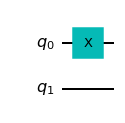

In [ ]:
qc0 = QuantumCircuit(2)
qc0.x(0)
qc0.draw('mpl')

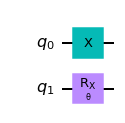

In [ ]:
theta0 = Parameter('θ')
qc1 = QuantumCircuit(2)
qc1.x(0)
qc1.rx(theta0, 1)
qc1.draw('mpl')

In [ ]:
state0 = CircuitStateFn(qc0)
purity = compute_uncompute_overlap(state0)
purity

1.0

In [ ]:
theta_values = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
param_dict = {theta0: theta_values}

In [ ]:
state0 = CircuitStateFn(qc0)
state1 = CircuitStateFn(qc1).bind_parameters(param_dict)
overlaps = compute_uncompute_overlap(state0, state1)
overlaps

array([1. , 0.5, 0. , 0.5, 1. ])

In [ ]:
param_state = CircuitStateFn(qc1)
overlaps = compute_uncompute_overlap(param_state, param_dict=param_dict)
overlaps

array([[1. , 0.5, 0. , 0.5, 1. ],
       [0.5, 1. , 0.5, 0. , 0.5],
       [0. , 0.5, 1. , 0.5, 0. ],
       [0.5, 0. , 0.5, 1. , 0.5],
       [1. , 0.5, 0. , 0.5, 1. ]])

In [ ]:
overlaps.diagonal()

array([1., 1., 1., 1., 1.])

Compare with a noisy simulator

In [ ]:
backend = QasmSimulator.from_backend(FakeVigo())
o = compute_uncompute_overlap(param_state, param_dict=param_dict, backend=backend)
np.round(o, 3)

array([[0.905, 0.488, 0.031, 0.487, 0.918],
       [0.488, 0.911, 0.48 , 0.039, 0.454],
       [0.031, 0.48 , 0.919, 0.483, 0.036],
       [0.487, 0.039, 0.483, 0.91 , 0.454],
       [0.918, 0.454, 0.036, 0.454, 0.923]])